=== Phishing Website Detection System ===

Choose an option:
1. Load dataset from file
2. Use sample dataset for demonstration
Enter your choice (1 or 2): 2
Using sample dataset for demonstration...

Preparing dataset...
Processing 20 URLs...
Dataset prepared with 20 samples and 34 features
Dataset prepared with 34 features

Training models...
Training Random Forest...
  Accuracy: 1.0000, F1-score: 1.0000
Training Gradient Boosting...
  Accuracy: 1.0000, F1-score: 1.0000
Training Logistic Regression...
  Accuracy: 1.0000, F1-score: 1.0000
Training SVM...
  Accuracy: 1.0000, F1-score: 1.0000
Training Naive Bayes...
  Accuracy: 1.0000, F1-score: 1.0000

Best model: Random Forest (F1-score: 1.0000)

Evaluating model...

=== Classification Report ===
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00         2
    Phishing       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00  

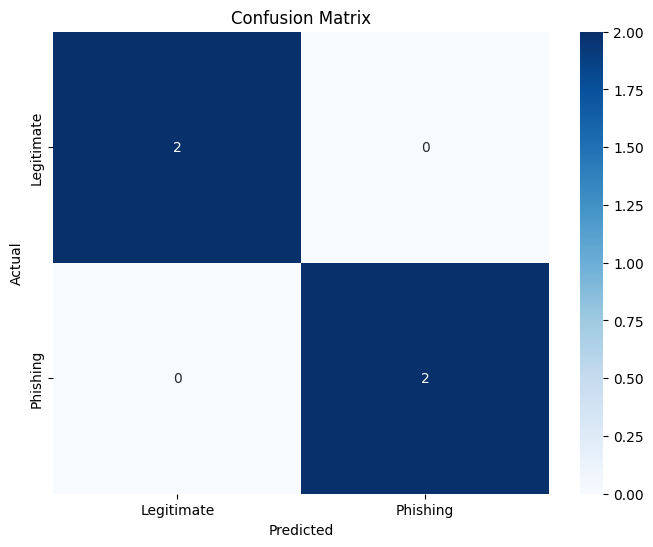

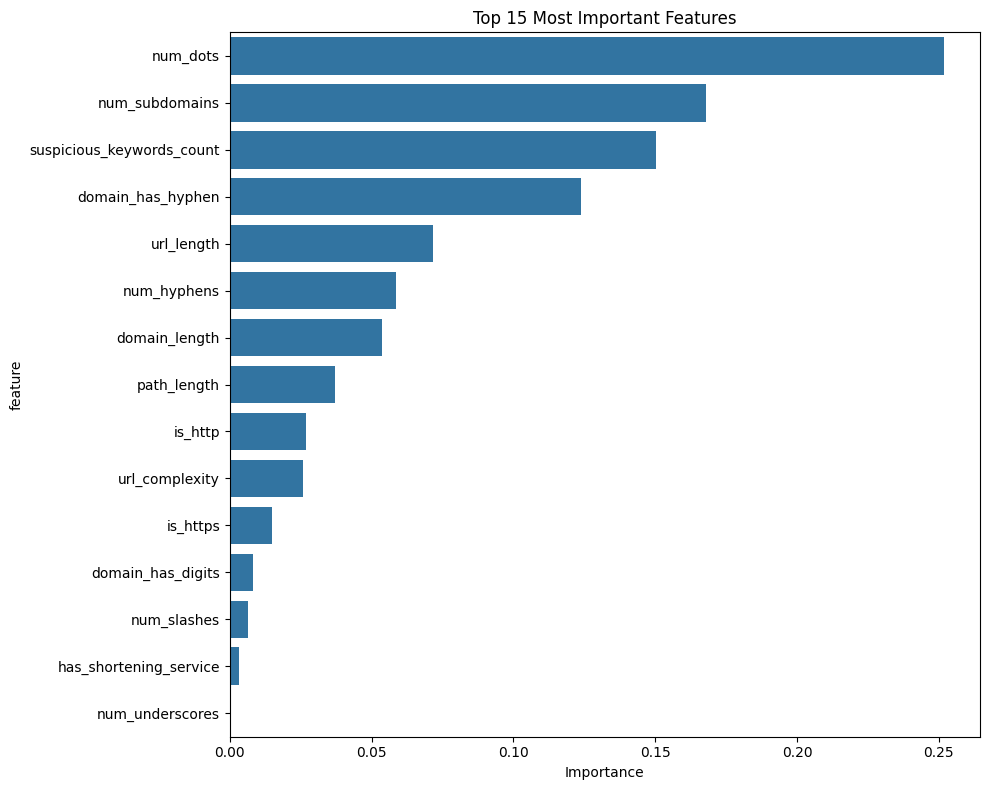


Top 10 Most Important Features:
                  feature  importance
                 num_dots    0.251916
           num_subdomains    0.167742
suspicious_keywords_count    0.150290
        domain_has_hyphen    0.123763
               url_length    0.071725
              num_hyphens    0.058691
            domain_length    0.053531
              path_length    0.037208
                  is_http    0.026891
           url_complexity    0.025718

=== Testing with Sample URLs ===

URL: https://www.google.com/search?q=python
Prediction: Legitimate
Confidence: 87.00%

URL: http://suspicious-site.com/login
Prediction: Phishing
Confidence: 88.00%

URL: https://amazon-security-update.com/verify
Prediction: Phishing
Confidence: 98.00%

=== System Ready ===
You can now use detector.predict_url('your_url_here') to test individual URLs


In [ ]:
import pandas as pd
import numpy as np
import re
from urllib.parse import urlparse
import requests
from bs4 import BeautifulSoup
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')


class PhishingDetector:
    """A comprehensive phishing website detection system using machine learning."""

    def __init__(self):
        self.scaler = StandardScaler()
        self.model = None
        self.feature_names = None

    def extract_basic_url_features(self, url):
        """Extract basic features from URL structure."""
        features = {}

        try:
            parsed_url = urlparse(url)
            domain = parsed_url.netloc
            path = parsed_url.path

            # URL length features
            features.update({
                'url_length': len(url),
                'domain_length': len(domain),
                'path_length': len(path)
            })

            # Character count features
            char_counts = {
                'num_dots': url.count('.'),
                'num_hyphens': url.count('-'),
                'num_underscores': url.count('_'),
                'num_slashes': url.count('/'),
                'num_question_marks': url.count('?'),
                'num_equal_signs': url.count('='),
                'num_at_signs': url.count('@'),
                'num_and_signs': url.count('&'),
                'num_exclamation_marks': url.count('!'),
                'num_space': url.count(' '),
                'num_tilde': url.count('~'),
                'num_comma': url.count(','),
                'num_plus': url.count('+'),
                'num_asterisk': url.count('*'),
                'num_hashtag': url.count('#'),
                'num_dollar': url.count('$'),
                'num_percent': url.count('%')
            }
            features.update(char_counts)

            return features

        except Exception as e:
            print(f"Error extracting basic features from {url}: {e}")
            # Return a dictionary with default values if extraction fails
            return {
                'url_length': 0, 'domain_length': 0, 'path_length': 0,
                'num_dots': 0, 'num_hyphens': 0, 'num_underscores': 0,
                'num_slashes': 0, 'num_question_marks': 0, 'num_equal_signs': 0,
                'num_at_signs': 0, 'num_and_signs': 0, 'num_exclamation_marks': 0,
                'num_space': 0, 'num_tilde': 0, 'num_comma': 0,
                'num_plus': 0, 'num_asterisk': 0, 'num_hashtag': 0,
                'num_dollar': 0, 'num_percent': 0
            }

    def extract_suspicious_patterns(self, url):
        """Extract features based on suspicious URL patterns."""
        features = {}

        try:
            parsed_url = urlparse(url)
            domain = parsed_url.netloc
            path = parsed_url.path

            # IP address detection
            features['has_ip_address'] = 1 if re.match(r'^[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+', domain) else 0

            # Port number detection
            features['has_port_number'] = 1 if ':' in domain and not domain.startswith('https://') else 0

            # URL shortening services
            shortening_services = ['bit.ly', 'tinyurl.com', 'short.link', 'ow.ly', 't.co', 'goo.gl']
            features['has_shortening_service'] = 1 if any(service in domain for service in shortening_services) else 0

            # Domain features
            features['domain_has_hyphen'] = 1 if '-' in domain else 0
            features['domain_has_digits'] = 1 if any(char.isdigit() for char in domain) else 0
            features['num_subdomains'] = max(0, len(domain.split('.')) - 2)

            # Path features
            features['path_has_double_slash'] = 1 if '//' in path else 0
            redirect_keywords = ['redirect', 'url', 'link', 'goto', 'out', 'away']
            features['path_has_redirect'] = 1 if any(keyword in path.lower() for keyword in redirect_keywords) else 0

            return features

        except Exception as e:
            print(f"Error extracting suspicious patterns from {url}: {e}")
            # Return a dictionary with default values if extraction fails
            return {
                'has_ip_address': 0, 'has_port_number': 0, 'has_shortening_service': 0,
                'domain_has_hyphen': 0, 'domain_has_digits': 0, 'num_subdomains': 0,
                'path_has_double_slash': 0, 'path_has_redirect': 0
            }


    def extract_protocol_and_security_features(self, url):
        """Extract protocol and security-related features."""
        features = {}

        try:
            parsed_url = urlparse(url)

            # Protocol features
            features['is_https'] = 1 if parsed_url.scheme == 'https' else 0
            features['is_http'] = 1 if parsed_url.scheme == 'http' else 0

            # Suspicious keywords
            suspicious_keywords = [
                'secure', 'account', 'update', 'login', 'signin', 'bank',
                'verify', 'confirm', 'suspend', 'restricted', 'limited',
                'amazon', 'paypal', 'ebay', 'apple', 'microsoft', 'google'
            ]
            features['suspicious_keywords_count'] = sum(1 for keyword in suspicious_keywords
                                                      if keyword in url.lower())

            # TLD analysis
            domain = parsed_url.netloc
            tld = domain.split('.')[-1] if '.' in domain else ''
            suspicious_tlds = ['tk', 'ml', 'ga', 'cf', 'top', 'click', 'download', 'link']
            features['suspicious_tld'] = 1 if tld in suspicious_tlds else 0

            # Domain complexity
            features['domain_age_suspicious'] = 1 if len(domain.split('.')) > 3 else 0

            return features

        except Exception as e:
            print(f"Error extracting protocol features from {url}: {e}")
            # Return a dictionary with default values if extraction fails
            return {
                'is_https': 0, 'is_http': 0, 'suspicious_keywords_count': 0,
                'suspicious_tld': 0, 'domain_age_suspicious': 0
            }


    def extract_url_features(self, url):
        """Extract comprehensive features from URL by combining all feature extraction methods."""
        # Combine all feature extraction methods
        basic_features = self.extract_basic_url_features(url)
        suspicious_features = self.extract_suspicious_patterns(url)
        protocol_features = self.extract_protocol_and_security_features(url)

        # Merge all features
        all_features = {**basic_features, **suspicious_features, **protocol_features}

        # Calculate URL complexity
        complexity_components = [
            all_features.get('num_dots', 0),
            all_features.get('num_hyphens', 0),
            all_features.get('num_underscores', 0),
            all_features.get('num_slashes', 0),
            all_features.get('num_question_marks', 0),
            all_features.get('num_equal_signs', 0)
        ]
        all_features['url_complexity'] = sum(complexity_components)

        # Ensure all features are present, even if a sub-extraction failed
        expected_features = self.feature_names if self.feature_names else all_features.keys()
        for feature in expected_features:
            if feature not in all_features:
                all_features[feature] = 0

        # Order features consistently
        if self.feature_names:
            ordered_features = {feature: all_features.get(feature, 0) for feature in self.feature_names}
            return ordered_features
        else:
            return all_features


    def extract_web_content_features(self, url):
        """Extract features from web content (requires HTTP request)."""
        features = {
            'response_status': 0,
            'response_time': 0,
            'content_length': 0,
            'num_forms': 0,
            'has_password_field': 0,
            'num_external_links': 0,
            'has_popup': 0
        }

        try:
            response = requests.get(url, timeout=10, verify=False)

            # Response metrics
            features['response_status'] = response.status_code
            features['response_time'] = response.elapsed.total_seconds()
            features['content_length'] = len(response.content)

            # Parse HTML content
            soup = BeautifulSoup(response.content, 'html.parser')

            # Form analysis
            forms = soup.find_all('form')
            features['num_forms'] = len(forms)
            features['has_password_field'] = 1 if any('password' in str(form).lower() for form in forms) else 0

            # Link analysis
            links = soup.find_all('a', href=True)
            domain = urlparse(url).netloc
            external_links = [link for link in links if domain not in link.get('href', '')]
            features['num_external_links'] = len(external_links)

            # Suspicious content patterns
            popup_keywords = ['popup', 'alert', 'confirm']
            features['has_popup'] = 1 if any(keyword in response.text.lower() for keyword in popup_keywords) else 0

        except Exception as e:
            print(f"Warning: Could not extract web content features from {url}: {e}")

        return features

    def prepare_dataset(self, urls, labels, include_web_content=False):
        """Prepare dataset by extracting features from URLs."""
        print(f"Processing {len(urls)} URLs...")
        features_list = []

        # Get initial feature names from the first URL to ensure consistency
        if not self.feature_names and urls:
            self.feature_names = list(self.extract_url_features(urls[0]).keys())
            if include_web_content:
                 self.feature_names.extend(list(self.extract_web_content_features(urls[0]).keys()))
            # Remove duplicates if any
            self.feature_names = list(dict.fromkeys(self.feature_names))


        for i, url in enumerate(urls):
            if i % 100 == 0 and i > 0:
                print(f"Processed {i}/{len(urls)} URLs")

            # Extract URL-based features
            features = self.extract_url_features(url)

            # Optionally include web content features
            if include_web_content:
                web_features = self.extract_web_content_features(url)
                features.update(web_features)

            # Ensure all features are present and in the correct order
            ordered_features = {feature: features.get(feature, 0) for feature in self.feature_names}
            features_list.append(ordered_features)


        # Create DataFrame
        df = pd.DataFrame(features_list)
        df['label'] = labels

        print(f"Dataset prepared with {df.shape[0]} samples and {df.shape[1]-1} features")
        return df

    def train_models(self, df, test_size=0.2, random_state=42):
        """Train multiple models and select the best performer."""
        # Prepare data
        X = df.drop('label', axis=1)
        y = df['label']
        self.feature_names = X.columns.tolist()

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Scale features for certain models
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Define models
        models = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=random_state),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=random_state),
            'Logistic Regression': LogisticRegression(random_state=random_state, max_iter=1000),
            'SVM': SVC(random_state=random_state, probability=True),
            'Naive Bayes': GaussianNB()
        }

        # Train and evaluate models
        results = self._evaluate_models(models, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test)

        # Select best model
        best_model_name = max(results.keys(), key=lambda x: results[x]['f1_score'])
        self.model = results[best_model_name]['model']

        print(f"\nBest model: {best_model_name} (F1-score: {results[best_model_name]['f1_score']:.4f})")
        return results, X_test, y_test

    def _evaluate_models(self, models, X_train, X_train_scaled, X_test, X_test_scaled, y_train, y_test):
        """Helper method to evaluate multiple models."""
        results = {}
        scaling_models = ['Logistic Regression', 'SVM', 'Naive Bayes']

        for name, model in models.items():
            print(f"Training {name}...")

            # Choose appropriate training data
            if name in scaling_models:
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            # Calculate metrics
            metrics = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred, average='weighted'),
                'recall': recall_score(y_test, y_pred, average='weighted'),
                'f1_score': f1_score(y_test, y_pred, average='weighted'),
                'model': model
            }

            results[name] = metrics
            print(f"  Accuracy: {metrics['accuracy']:.4f}, F1-score: {metrics['f1_score']:.4f}")

        return results

    def evaluate_model(self, X_test, y_test):
        """Provide detailed evaluation of the trained model."""
        if self.model is None:
            print("No model trained yet!")
            return

        # Make predictions
        y_pred = self._predict_with_scaling(X_test)

        # Classification report
        print("\n=== Classification Report ===")
        print(classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing']))

        # Confusion matrix visualization
        self._plot_confusion_matrix(y_test, y_pred)

        # Feature importance (for applicable models)
        self._plot_feature_importance()

    def _predict_with_scaling(self, X):
        """Helper method to make predictions with appropriate scaling."""
        scaling_models = (LogisticRegression, SVC, GaussianNB)

        if isinstance(self.model, scaling_models):
            X_scaled = self.scaler.transform(X)
            return self.model.predict(X_scaled)
        else:
            return self.model.predict(X)

    def _plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix."""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Legitimate', 'Phishing'],
                    yticklabels=['Legitimate', 'Phishing'])
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    def _plot_feature_importance(self):
        """Plot feature importance for tree-based models."""
        tree_models = (RandomForestClassifier, GradientBoostingClassifier)

        if not isinstance(self.model, tree_models):
            return

        # Create feature importance DataFrame
        feature_importance = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Plot top features
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(15)
        sns.barplot(data=top_features, y='feature', x='importance')
        plt.title('Top 15 Most Important Features')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

        # Print top features
        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))


    def predict_url(self, url):
        """Predict whether a single URL is phishing or legitimate."""
        if self.model is None:
            print("No model trained yet!")
            return None

        # Extract features and make prediction
        features = self.extract_url_features(url)
        # Ensure all features are present and in the correct order
        ordered_features = {feature: features.get(feature, 0) for feature in self.feature_names}
        # Create a DataFrame with the same columns as the training data
        df = pd.DataFrame([ordered_features], columns=self.feature_names)


        # Get prediction
        prediction = self._predict_with_scaling(df)[0]
        result = "Phishing" if prediction == 1 else "Legitimate"

        # Display results
        print(f"URL: {url}")
        print(f"Prediction: {result}")

        # Show confidence if available
        self._show_prediction_confidence(df, prediction)

        return prediction

    def _show_prediction_confidence(self, df, prediction):
        """Show prediction confidence if the model supports probability estimation."""
        if not hasattr(self.model, 'predict_proba'):
            return

        try:
            scaling_models = (LogisticRegression, SVC, GaussianNB)

            if isinstance(self.model, scaling_models):
                df_scaled = self.scaler.transform(df)
                probabilities = self.model.predict_proba(df_scaled)[0]
            else:
                probabilities = self.model.predict_proba(df)[0]

            confidence = max(probabilities) * 100
            print(f"Confidence: {confidence:.2f}%")

        except Exception as e:
            print(f"Could not calculate confidence: {e}")


# Dataset handling functions
def create_sample_dataset():
    """Create a sample dataset for demonstration purposes."""
    legitimate_urls = [
        "https://www.google.com",
        "https://www.amazon.com/product/123",
        "https://www.github.com/user/repo",
        "https://www.stackoverflow.com/questions/123",
        "https://www.wikipedia.org/wiki/page",
        "https://www.linkedin.com/in/user",
        "https://www.youtube.com/watch?v=123",
        "https://www.facebook.com/page",
        "https://www.twitter.com/user",
        "https://www.reddit.com/r/subreddit"
    ]

    phishing_urls = [
        "http://amaz0n.com/account/update",
        "https://paypal-security.com/verify",
        "http://gooogle.com/signin",
        "https://appleid-verification.com/login",
        "http://microsoft-update.com/security",
        "https://facebook-security.com/account",
        "http://twitter-verify.com/login",
        "https://bank-update.com/account/verify",
        "http://amazon-security.com/signin",
        "https://paypal-verify.com/account/update"
    ]

    urls = legitimate_urls + phishing_urls
    labels = [0] * len(legitimate_urls) + [1] * len(phishing_urls)

    return urls, labels


def load_dataset_from_file(file_path):
    """Load and analyze a dataset from file."""
    print(f"Loading dataset from: {file_path}")

    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        print("\nFirst few rows:")
        print(df.head())

        # Identify potential URL and label columns
        url_columns = [col for col in df.columns if 'url' in col.lower()]
        label_keywords = ['label', 'class', 'target', 'phishing', 'result']
        label_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in label_keywords)]

        print(f"\nPossible URL columns: {url_columns}")
        print(f"Possible label columns: {label_columns}")

        # Show label distribution
        for col in label_columns:
            print(f"\nUnique values in '{col}': {df[col].unique()}")
            print(f"Value counts:\n{df[col].value_counts()}")

        return df

    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None


def process_dataset(df, url_column=None, label_column=None):
    """Process the dataset to extract URLs and convert labels to binary format."""

    # Auto-detect columns if not specified
    if url_column is None:
        url_columns = [col for col in df.columns if 'url' in col.lower()]
        if url_columns:
            url_column = url_columns[0]
            print(f"Using URL column: {url_column}")
        else:
            print("Error: No URL column found!")
            return None, None

    if label_column is None:
        label_keywords = ['label', 'class', 'target', 'phishing', 'result']
        label_columns = [col for col in df.columns if any(keyword in col.lower() for keyword in label_keywords)]
        if label_columns:
            label_column = label_columns[0]
            print(f"Using label column: {label_column}")
        else:
            print("Error: No label column found!")
            return None, None

    # Extract data
    urls = df[url_column].tolist()
    labels = df[label_column].tolist()

    # Convert labels to binary format
    processed_labels = convert_labels_to_binary(labels, df[label_column].unique())

    print(f"Label distribution - Legitimate: {processed_labels.count(0)}, Phishing: {processed_labels.count(1)}")

    return urls, processed_labels


def convert_labels_to_binary(labels, unique_labels):
    """Convert various label formats to binary (0=legitimate, 1=phishing)."""
    unique_set = set(unique_labels)

    # Already binary
    if unique_set == {0, 1}:
        return labels

    # String binary
    if unique_set == {'0', '1'}:
        return [int(label) for label in labels]

    # Text-based labels
    phishing_keywords = ['phishing', 'malicious', 'bad', 'suspicious']
    if any(keyword in str(unique_labels).lower() for keyword in phishing_keywords):
        processed_labels = []
        for label in labels:
            if any(keyword in str(label).lower() for keyword in phishing_keywords):
                processed_labels.append(1)
            else:
                processed_labels.append(0)
        return processed_labels

    # Default mapping: first unique value = legitimate, others = phishing
    label_mapping = {unique_labels[0]: 0}
    for label in unique_labels[1:]:
        label_mapping[label] = 1

    print(f"Label mapping: {label_mapping}")
    return [label_mapping[label] for label in labels]


def get_user_dataset_choice():
    """Get user's choice for dataset source."""
    print("Choose an option:")
    print("1. Load dataset from file")
    print("2. Use sample dataset for demonstration")

    while True:
        choice = input("Enter your choice (1 or 2): ").strip()
        if choice in ['1', '2']:
            return choice
        print("Please enter 1 or 2")


def main():
    """Main function to run the phishing detection system."""
    print("=== Phishing Website Detection System ===\n")

    # Get dataset choice
    choice = get_user_dataset_choice()

    if choice == "1":
        # Load custom dataset
        file_path = input("Enter the path to your dataset file: ").strip()
        df = load_dataset_from_file(file_path)

        if df is None:
            print("Failed to load dataset. Exiting.")
            return

        # Get column specifications
        url_col = input("Enter URL column name (or press Enter for auto-detection): ").strip() or None
        label_col = input("Enter label column name (or press Enter for auto-detection): ").strip() or None

        # Process dataset
        urls, labels = process_dataset(df, url_col, label_col)
        if urls is None:
            print("Failed to process dataset. Exiting.")
            return
    else:
        # Use sample dataset
        print("Using sample dataset for demonstration...")
        urls, labels = create_sample_dataset()

    # Initialize and train detector
    detector = PhishingDetector()

    print("\nPreparing dataset...")
    df = detector.prepare_dataset(urls, labels, include_web_content=False)

    print(f"Dataset prepared with {df.shape[1]-1} features")

    print("\nTraining models...")
    results, X_test, y_test = detector.train_models(df)

    print("\nEvaluating model...")
    detector.evaluate_model(X_test, y_test)

    # Test with sample URLs
    print("\n=== Testing with Sample URLs ===")
    test_urls = [
        "https://www.google.com/search?q=python",
        "http://suspicious-site.com/login",
        "https://amazon-security-update.com/verify"
    ]

    for url in test_urls:
        print()
        detector.predict_url(url)

    print("\n=== System Ready ===")
    print("You can now use detector.predict_url('your_url_here') to test individual URLs")


if __name__ == "__main__":
    main()